In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
import torch
import torch.functional as F
import numpy as np
import requests
import torchvision
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image


image = "CLIC/andy-kelly-0E_vhMVqL9g-unsplash.png"
image = np.array(Image.open(image))
rgb_img = np.float32(image) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
# Taken from the torchvision tutorial
# https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html
model = deeplabv3_resnet50(pretrained=True, progress=False)
model = model.eval()

# if torch.cuda.is_available():
#     model = model.cuda()
#     input_tensor = input_tensor.cuda()

output = model(input_tensor)
print(type(output), output.keys())

<class 'collections.OrderedDict'> odict_keys(['out', 'aux'])


In [2]:
class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model): 
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model
        
    def forward(self, x):
        return self.model(x)["out"]
    
model = SegmentationModelOutputWrapper(model)
output = model(input_tensor)

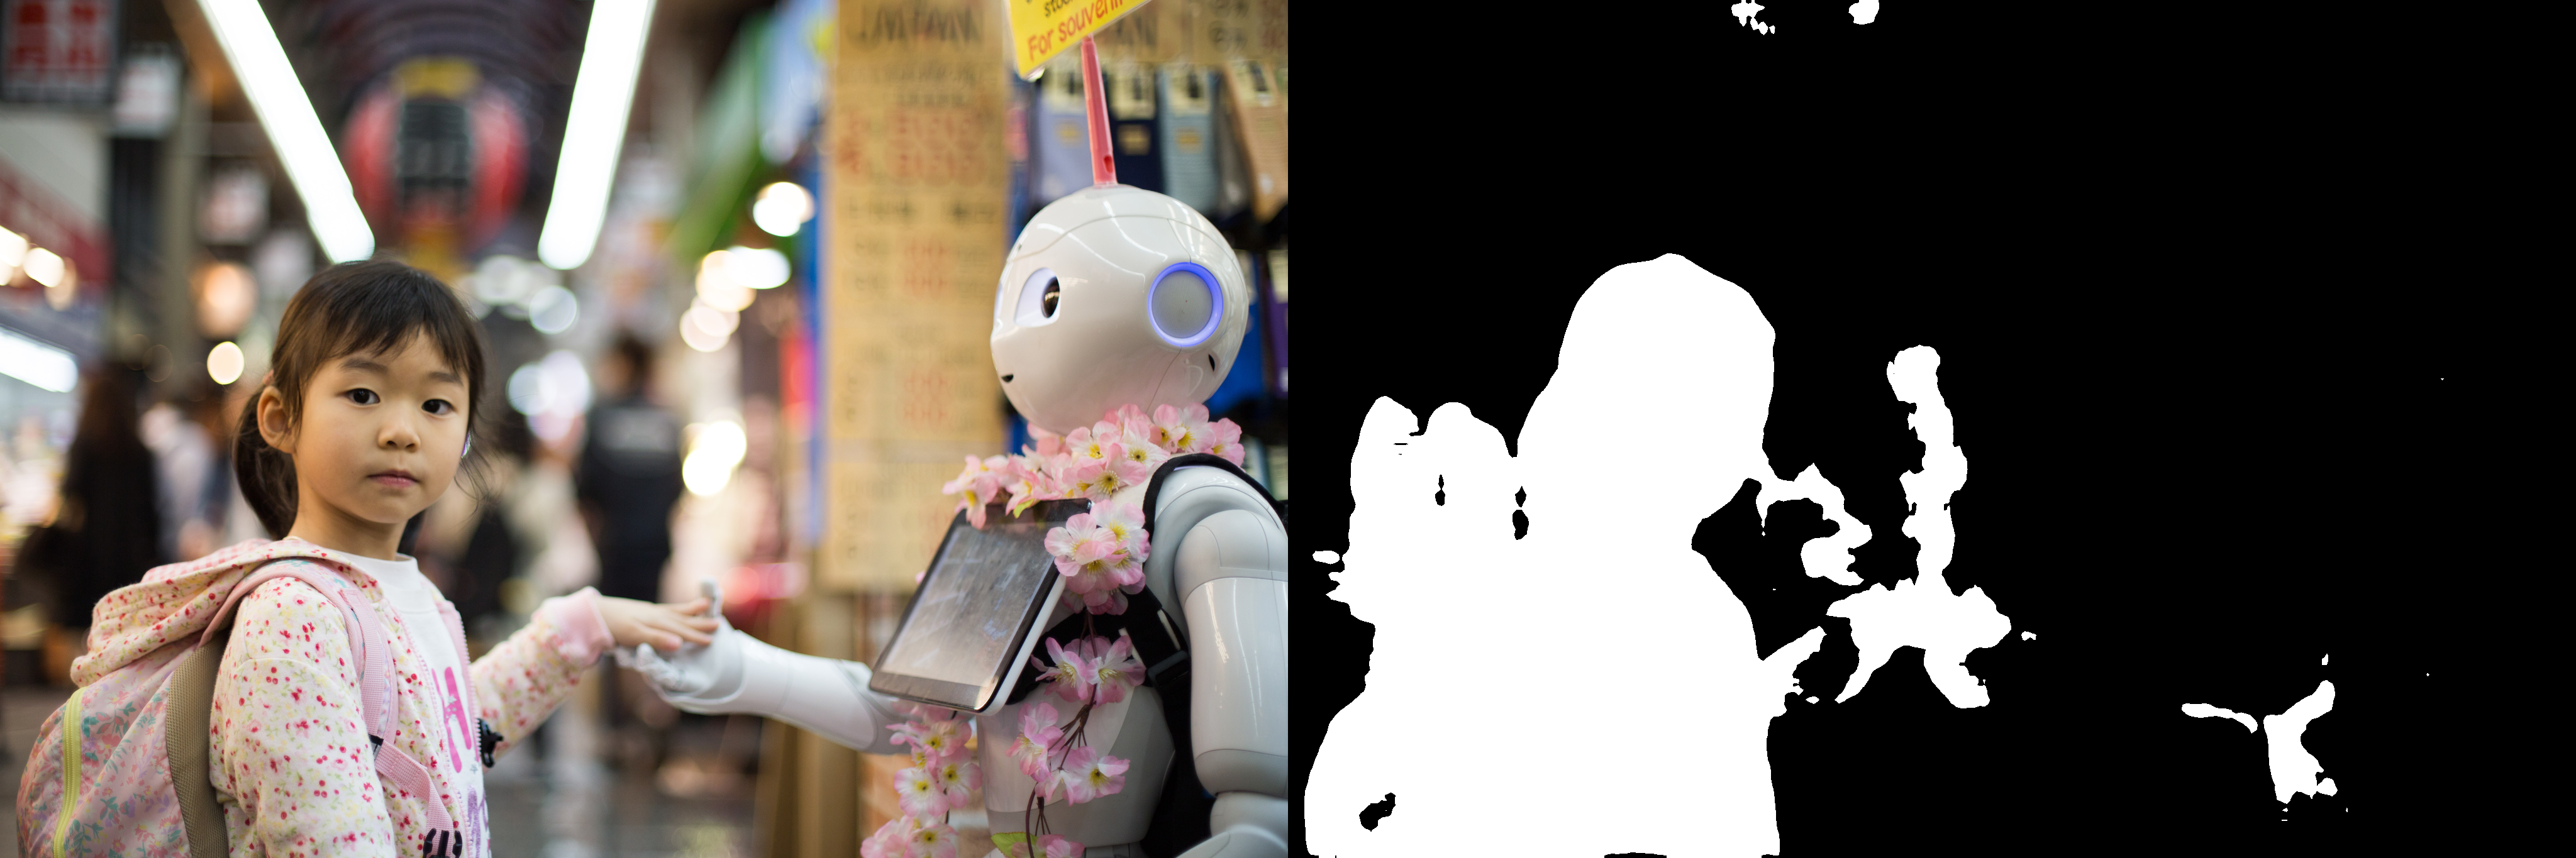

In [10]:
normalized_masks = torch.nn.functional.softmax(output, dim=1).cpu()
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

category_category = sem_class_to_idx["person"]
category_mask = normalized_masks[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
category_mask_uint8 = 255 * np.uint8(category_mask == category_category)
category_mask_float = np.float32(category_mask == category_category)

both_images = np.hstack((image, np.repeat(category_mask_uint8[:, :, None], 3, axis=-1)))
Image.fromarray(both_images)


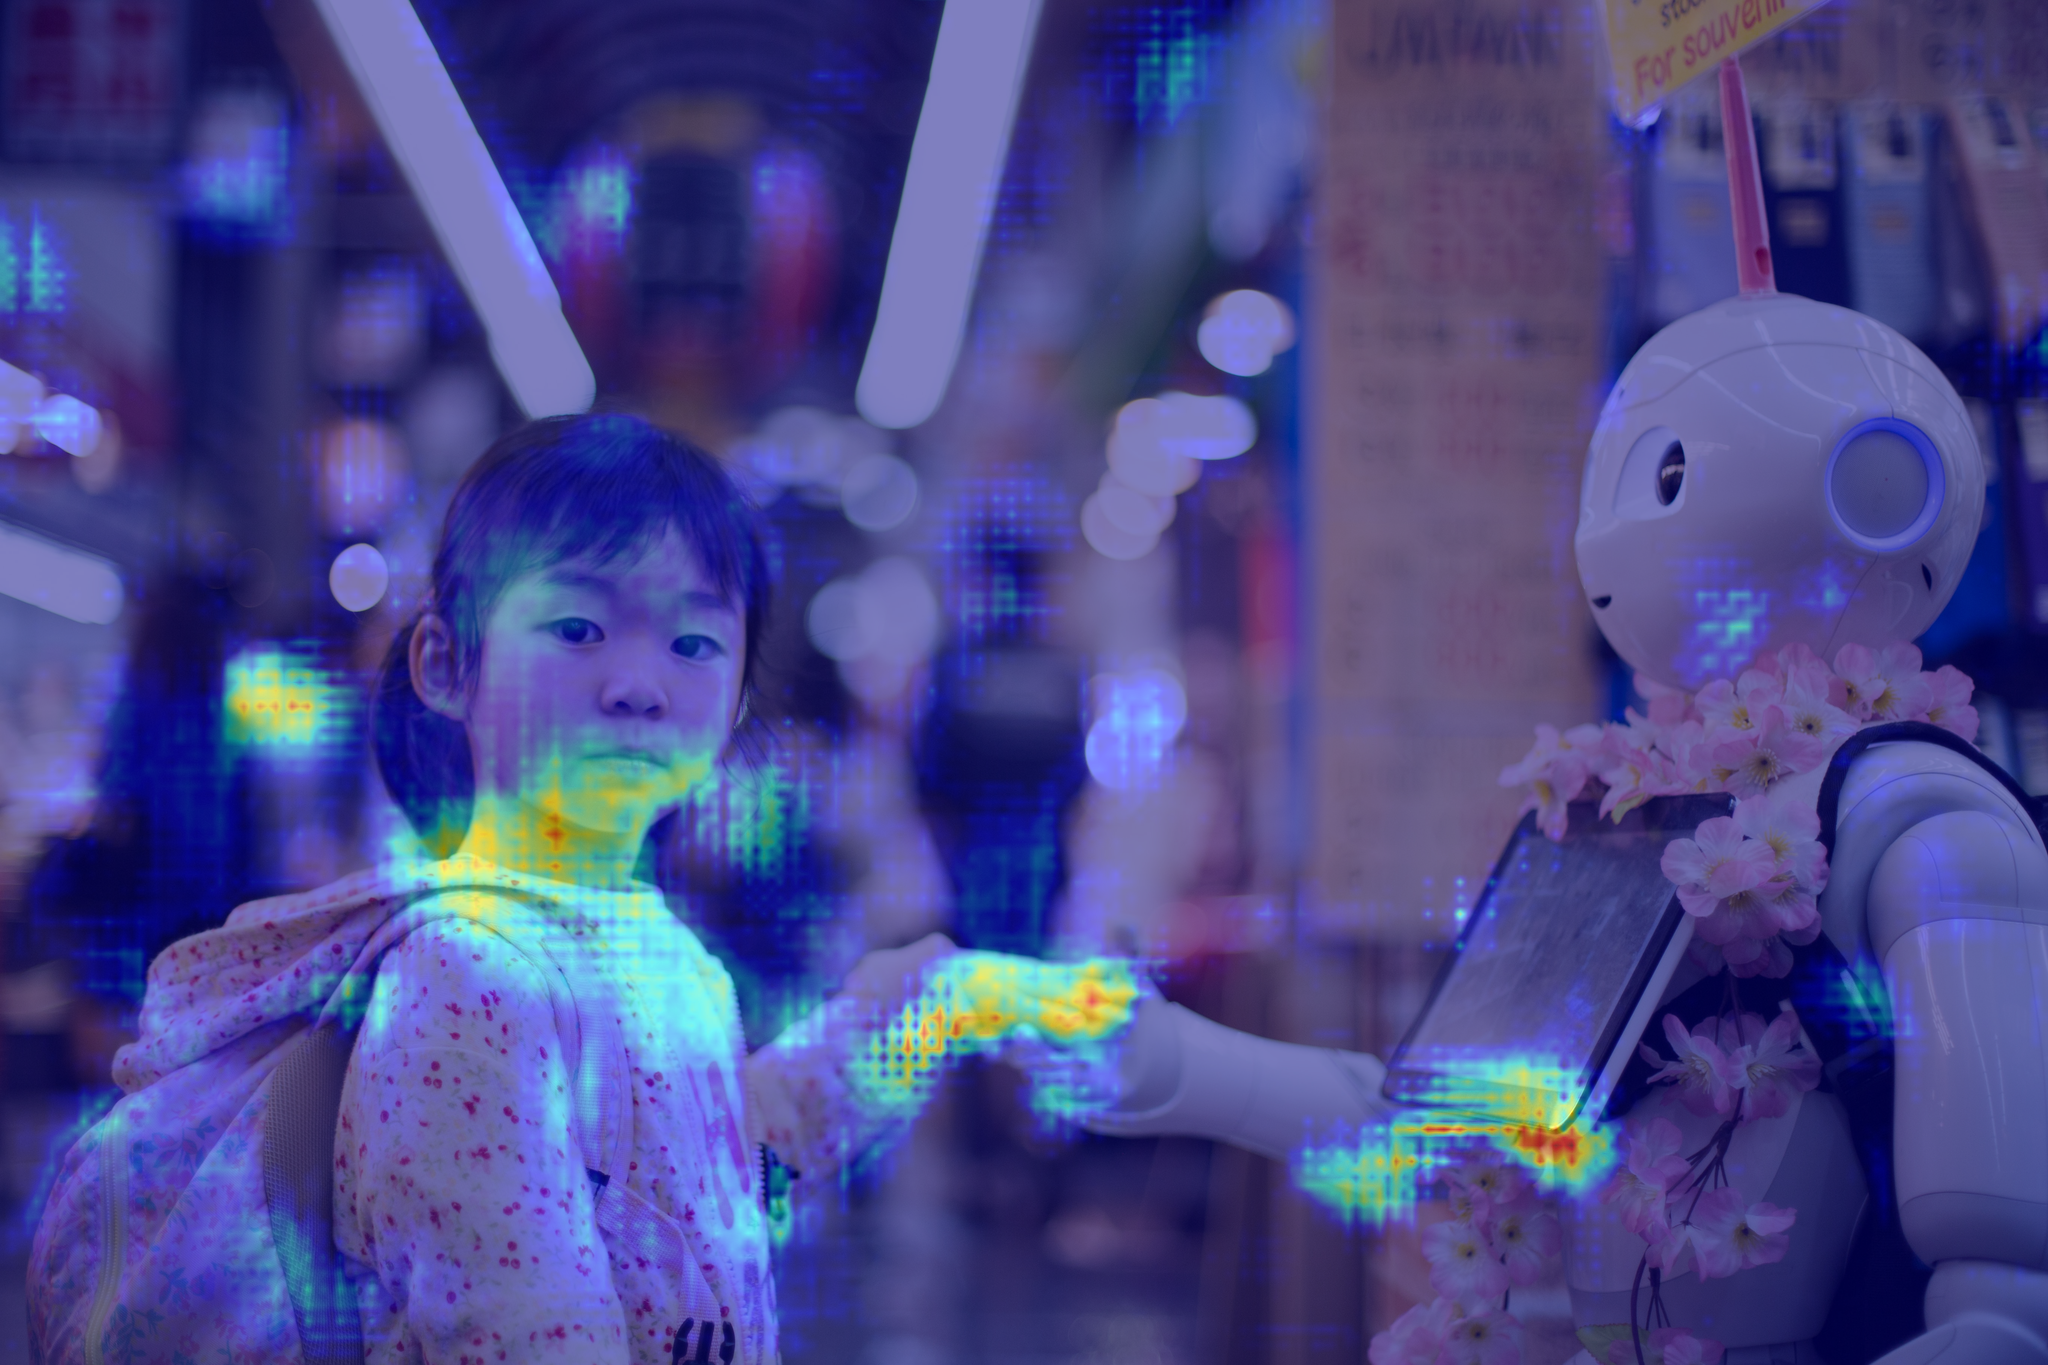

In [11]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        # if torch.cuda.is_available():
        #     self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()

    
target_layers = [model.model.backbone.layer4]
targets = [SemanticSegmentationTarget(category_category, category_mask_float)]
with GradCAM(model=model, target_layers=target_layers) as cam:
#  use_cuda=torch.cuda.is_available()) as cam:
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Image.fromarray(cam_image)

In [13]:
img_ori = Image.fromarray(image)
img_cam = Image.fromarray(cam_image)
img_sem = Image.fromarray(np.repeat(category_mask_uint8[:, :, None], 3, axis=-1))

img_ori.save('compressed_CLIC/ori_person_real.jpg')
img_cam.save('compressed_CLIC/cam_person_real.jpg')
img_sem.save('compressed_CLIC/sem_person_real.jpg')